In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import pickle

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import preprocessing, svm
from sklearn import neighbors
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from pandas_ml import ConfusionMatrix

from imblearn.over_sampling import SMOTE

- issuercountrycode: country where the card was issued
- txvariantcode: the card type that was used (subbrand of visa or master card)
- bin: card issuer identifier
- amount/currencycode: transaction amount in minor units (so 100 EUR = 100 euro cent)
- shoppercountrycode: IP address country
- shopperinteraction: Ecommerce if it was an online transaction, ContAuth if it was a (monthly) subscription
- simple_journal: Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud”
- bookingdate: only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.
- cardverificationresponsesupplied: did the shopper provide his 3 digit CVC/CVV2 code?
- cvcresponsecode: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
- creationdate: Date of transaction
- accountcode: merchant’s webshop
- mail_id: Email address
- ip_id: Ip address
- card_id: Card number

#### We've save the preprocessing file as dataset_preprocessing.pickle
#### How the preprocessing was done will be described below

In [91]:
#Load the preprocessed file to save the time
dataset = pd.read_pickle("dataset_preprocessing_1.pickle")

#### Look at the what the features are and the size of benign and malicious dataset

In [92]:
#dataset = pd.read_csv('data_for_student_case.csv')

#Drop unuseful feature
# dataset.drop('txid',inplace = True,axis = 1)

# dataset.drop(dataset.index[dataset['simple_journal']=='Refused'],inplace = True)

print("number of dataset = ",len(dataset))
print("number of card ids = ",len(dataset['card_id'].unique()))

frauds = dataset.loc[dataset['simple_journal']=='Chargeback']
print(frauds.head())
print("number of fraudulent data=",len(frauds))
card_ids = frauds['card_id'].unique()
print("number of card ids =", len(card_ids))



number of dataset =  237036
number of card ids =  210854
           bookingdate issuercountrycode txvariantcode       bin  amount  \
0  2015-11-09 14:26:51                MX      mccredit  530056.0     4.0   
1  2015-11-09 14:27:38                MX      mccredit  547046.0     3.0   
2  2015-11-23 16:34:16                MX      mccredit  528843.0     4.0   
3  2015-11-23 16:34:51                MX      mccredit  547146.0     4.0   
4  2015-11-09 14:26:08                MX   visaclassic  477291.0     4.0   

  currencycode shoppercountrycode shopperinteraction simple_journal  \
0          MXN                 MX          Ecommerce     Chargeback   
1          MXN                 MX          Ecommerce     Chargeback   
2          MXN                 MX          Ecommerce     Chargeback   
3          MXN                 MX          Ecommerce     Chargeback   
4          MXN                 MX          Ecommerce     Chargeback   

  cardverificationcodesupplied  cvcresponsecode         cre

# Preprocessing

### Change cvcresponsecode from 0-6 to 0-3

In [48]:
#Change cvcresponsecode from 0-6 to 0-3
# for index,row in dataset.iterrows():
#     if row['cvcresponsecode'] >3:
#         dataset.loc[index,'cvcresponsecode'] = 3
# print("done")


### Set regions into for the amount of transaction
- below 1000  : 0
- 1000  - 5000  : 1
- 5000  - 10000 : 2
- 10000 - 50000 : 3
- larger than 50000 : 4

In [ ]:
# set regions into for the amount of transaction
# dataset = pd.read_pickle("dataset_preprocessing.pickle")
# region_lists = [1000,5000,10000,50000]
# for index, row in dataset.iterrows():
#     if row['amount']<region_lists[0]:
#         dataset.loc[index,'amount'] = 0
#     if (row['amount']>=region_lists[0] and row['amount']<region_lists[1]):
#         dataset.loc[index,'amount'] = 1
#     if (row['amount']>=region_lists[1] and row['amount']<region_lists[2]):
#         dataset.loc[index,'amount'] = 2
#     if (row['amount']>=region_lists[2] and row['amount']<region_lists[3]):
#         dataset.loc[index,'amount'] = 3
#     if (row['amount']>=region_lists[3]):
#         dataset.loc[index,'amount'] = 4
# print(dataset.groupby(['amount']).size())

### Save to pickle file for easy loading

In [ ]:
# dataset.to_pickle('dataset_preprocessing_1.pickle')

# Task 1: Visualization

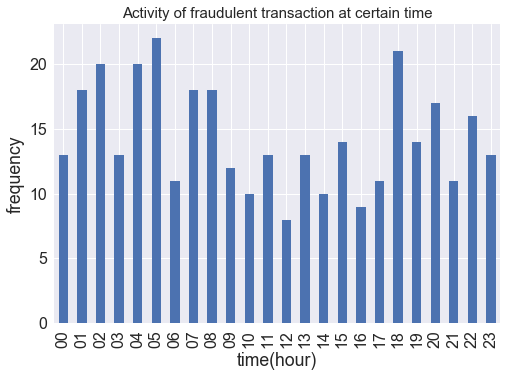

In [93]:
# Activity of the fraudulent transaction
dates = pd.DataFrame(frauds['creationdate'],columns = ['creationdate'])
Times = pd.DataFrame(dates.creationdate.str.split(' ').tolist(),columns=['years','times'])
Times_1 =  Times.times.str.split(":").tolist()
Times.times = np.array(Times_1)[:,0].tolist()
plt.close()
Times.groupby(['times']).count().plot(kind="bar",legend=False)
plt.title('Activity of fraudulent transaction at certain time',fontsize = 15)
plt.xlabel('time(hour)')
plt.ylabel('frequency')
# plt.savefig("fraud_activity_hour")
plt.show()




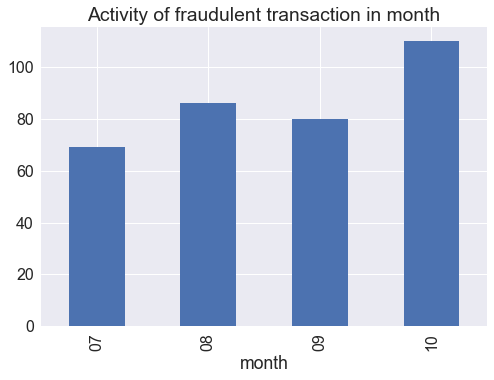

In [94]:
# Activity of the fraud transaction in months
dates = pd.DataFrame(frauds['creationdate'],columns = ['creationdate'])
Times = pd.DataFrame(dates.creationdate.str.split(' ').tolist(),columns=['years','times'])
Year_1 =  Times.years.str.split("-").tolist()
Year_data = pd.DataFrame(np.array(Year_1)[:,1:].tolist(),columns=['month','date'])

# Year_data = pd.DataFrame({'count':Year_data.groupby(['month','date']).size()}).reset_index()
plt.clf()
Year_data.groupby(['month']).count().plot(kind = "bar",legend = False)
plt.title("Activity of fraudulent transaction in month")
plt.show()



simple_journal  cvcresponsecode
Chargeback      0                     303
                1                      42
Settled         0                   43852
                1                  192663
                2                       8
                3                     168
dtype: int64


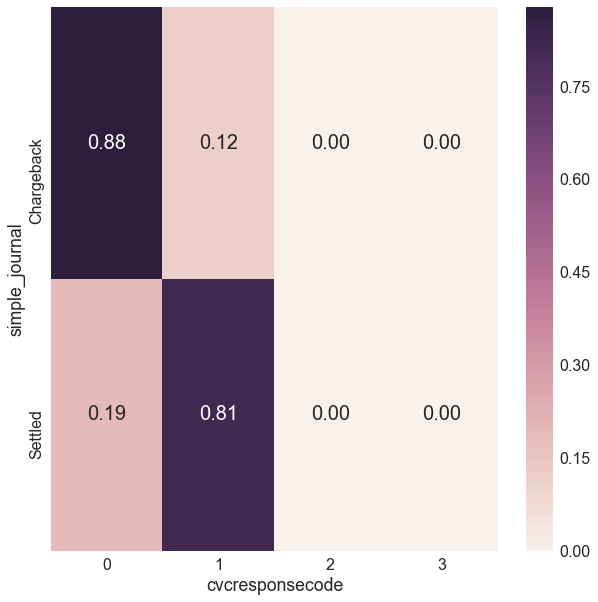

In [95]:
# validation of cvc response code to benign and malicious data
print(dataset.groupby(['simple_journal','cvcresponsecode']).size())
d2 = pd.read_pickle('dataset_preprocessing.pickle')
# d2 = dataset[['simple_journal','cardverificationcodesupplied']]
d2 = dataset[['simple_journal','cvcresponsecode']]
d3 = pd.DataFrame({'count':d2.groupby(['simple_journal','cvcresponsecode']).size()}).reset_index()
# print(d3)
d4 = d3.pivot(index = 'simple_journal',columns = 'cvcresponsecode',values= 'count')
# print("\n\n")
d4.replace("NaN",0,inplace = True)
d5 = d4.div(d4.sum(axis=1), axis=0)
# print(d4)
# print("\n\n")
# print(d5)

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.6)
a = sns.heatmap(d5, annot=True, fmt=".2f",ax=ax,annot_kws={"size": 20})
# plt.savefig("cvcprovide_comparison")
plt.show(a)

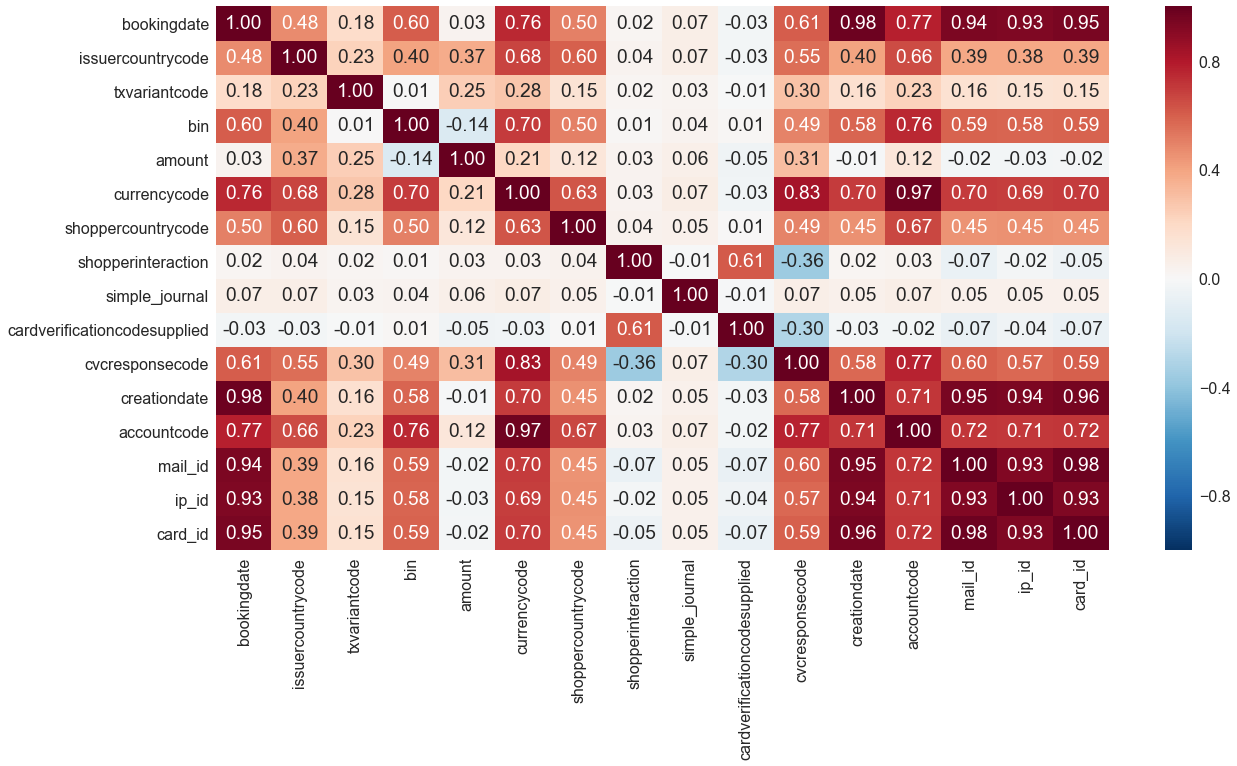

In [96]:
# Correlation mamatrix after factorizing all features
factorize_all = dataset.apply(lambda x: x.factorize()[0]).corr()
plt.clf()
fig, ax = plt.subplots(figsize=(20,10))
a = sns.heatmap(factorize_all, annot=True, fmt=".2f",ax=ax)
plt.show(a)

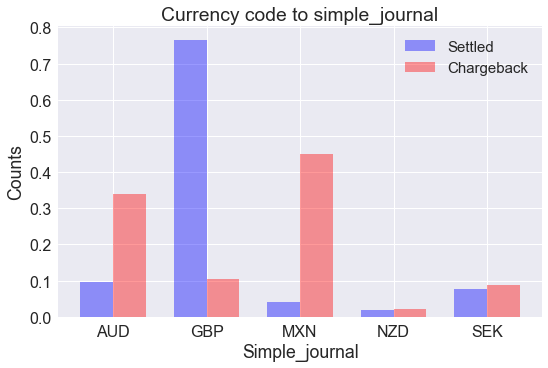

In [97]:
# Currencycode to both types of transaction
# print(dataset.groupby(['simple_journal','currencycode']).size())
# print(dataset.groupby(['simple_journal','currencycode']).size().tolist())
Chargeback = np.array(dataset.groupby(['simple_journal','currencycode']).size().tolist()[0:5])
Chargeback = Chargeback/Chargeback.sum()
Settled = np.array(dataset.groupby(['simple_journal','currencycode']).size().tolist()[5:])
Settled = Settled/Settled.sum()

plt.clf()
fig, ax = plt.subplots()
index = np.arange(len(Chargeback))
bar_width = 0.35
opacity = 0.4
rects1 = ax.bar(index, Settled, bar_width,
                alpha=opacity, color='b',
                label='Settled')

rects2 = ax.bar(index + bar_width, Chargeback, bar_width,
                alpha=opacity, color='r',
                label='Chargeback')

ax.set_xlabel('Simple_journal')
ax.set_ylabel('Counts')
ax.set_title('Currency code to simple_journal')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('AUD', 'GBP', 'MXN', 'NZD', 'SEK'))
ax.legend()
plt.legend( prop={'size': 15})

fig.tight_layout()
# plt.savefig("currencycode_simplejournal")
plt.show()






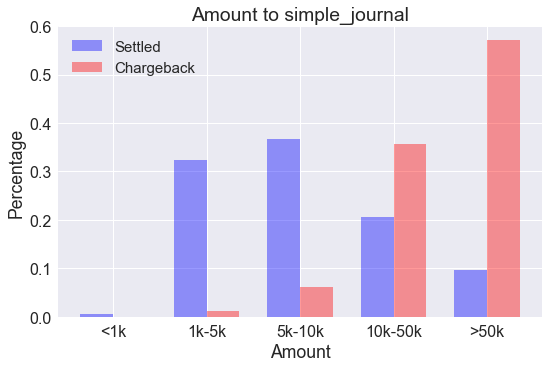

In [54]:
# Comparison of amount to transaction data
t = pd.read_pickle("dataset_preprocessing_1.pickle")
# print(t.groupby(['amount']).size())
# print(t.groupby(['simple_journal','amount']).size())
# print(t.groupby(['simple_journal','amount']).size().tolist())
amount_list = t.groupby(['simple_journal','amount']).size().tolist()
amount_list.insert(0,0)
Chargeback = np.array(amount_list[0:5])
Settled = np.array(amount_list[5:10])
Chargeback = Chargeback/Chargeback.sum()
Settled = Settled/Settled.sum()

plt.clf()
fig, ax = plt.subplots()

index = np.arange(len(Chargeback))
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, Settled, bar_width,
                alpha=opacity, color='b',
                label='Settled')

rects2 = ax.bar(index + bar_width, Chargeback, bar_width,
                alpha=opacity, color='r',
                label='Chargeback')

ax.set_xlabel('Amount')
ax.set_ylabel('Percentage')
ax.set_title('Amount to simple_journal')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('<1k', '1k-5k', '5k-10k', '10k-50k', '>50k'))
ax.legend()
plt.legend( prop={'size': 15})
fig.tight_layout()
# plt.savefig("amount_simplejournal")
plt.show()







# Code of training and testing with SMOTE

In [99]:
#load
dataset = pd.read_pickle("dataset_preprocessing_1.pickle")

dataset_1 = dataset
#normalization
# dataset_1['bin'] = (dataset['bin']-dataset['bin'].mean())/dataset['bin'].std()
# dataset_1['amount'] = (dataset['amount']-dataset['amount'].mean())/dataset['amount'].std()

#separate features for factorization, dummie, or maintain the same
dataset_2 = dataset_1[['amount']]
dataset_1.drop(['amount'],axis =1,inplace=True)
#dummie
dataset_dummies = dataset_1[['shopperinteraction','issuercountrycode','currencycode','txvariantcode','cvcresponsecode','cardverificationcodesupplied']]
dataset_dummies = pd.get_dummies(dataset_dummies)
#factorize
dataset_1.drop(['shopperinteraction','issuercountrycode','currencycode','txvariantcode','cvcresponsecode','cardverificationcodesupplied'],axis = 1,inplace = True)
dataset_1 = dataset_1.apply(lambda x: x.factorize()[0])
#concatenate into one dataframe
factorize_all_1 = pd.concat([dataset_1,dataset_dummies,dataset_2],axis =1)
factorize_all_1.drop(['creationdate','bookingdate','mail_id','ip_id','card_id'],axis = 1,inplace = True)

#To solve the sparsity, manually separate the benign and malicious data for training and testing
X_fraud = factorize_all_1.loc[dataset['simple_journal']=='Chargeback']
X_nonfraud = factorize_all_1.loc[dataset['simple_journal']!='Chargeback']

##shuffle the data and split(fraud)
X_fraud = X_fraud.sample(frac = 1).reset_index(drop=True)

##shuffle the data and split(non-fraud)
X_nonfraud = X_nonfraud.sample(frac = 1).reset_index(drop=True)


####create lists
k_fraud = len(X_fraud)
i_fraud = int((k_fraud/10))
z_fraud = len(X_fraud)-i_fraud*9
lists_fraud = np.ones((1,9))*i_fraud
lists_fraud = np.append(lists_fraud,z_fraud).tolist()
start_fraud = 0

k_nonfraud = len(X_nonfraud)
i_nonfraud = int((k_nonfraud/10))
z_nonfraud= len(X_nonfraud)-i_nonfraud*9
lists_nonfraud = np.ones((1,9))*i_nonfraud
lists_nonfraud = np.append(lists_nonfraud,z_nonfraud).tolist()
start_nonfraud = 0
confusion_lists = []
TP,FP,FN,TN = 0,0,0,0

for i in range(10):
    X_test_fraud = X_fraud[int(start_fraud):(int(start_fraud)+int(lists_fraud[i])+1)]
    X_train_fraud = X_fraud.drop(X_test_fraud.index, axis = 0)
#     print(len(X_train_fraud),len(X_test_fraud),len(X_fraud))
    print("The %d -th fold" %(i+1))
    
    X_test_nonfraud = X_nonfraud[int(start_nonfraud):(int(start_nonfraud)+int(lists_nonfraud[i])+1)]
    X_train_nonfraud = X_nonfraud.drop(X_test_nonfraud.index, axis = 0)
    
    Test = [X_test_fraud,X_test_nonfraud]
    Test = pd.concat(Test)
    Test_y = Test['simple_journal']
    Test_X = Test.drop(['simple_journal'],axis = 1)
    Test_y_np = np.array(Test_y)
    Test_X_np = np.array(Test_X)
    
    
    Train_SMOTE = [X_train_fraud,X_train_nonfraud]
    Train_SMOTE = pd.concat(Train_SMOTE)
    Train_y = Train_SMOTE['simple_journal']
    Train_X = Train_SMOTE.drop(['simple_journal'],axis =1)
    
    #### SMOTE ###
    Train_X_resample, Train_y_resample = SMOTE(k_neighbors = 250).fit_sample(Train_X, Train_y)
    
    #### np.array ###
    Train_X_np = np.array(Train_X_resample)
    Train_y_np = np.array(Train_y_resample)

    #Classifiers
#     rf_clf = RandomForestClassifier(n_estimators = 10)
#     rf_clf = neighbors.KNeighborsClassifier(algorithm="kd_tree") #KNN
#     rf_clf = LogisticRegression()
    rf_clf = ExtraTreesClassifier(bootstrap = True)
#     rf_clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators = 10))
#     rf_clf = LinearRegression()
#     rf_clf = DecisionTreeClassifier()

    ##Voting
#     clf1 = RandomForestClassifier(n_estimators = 10)
#     clf2 = ExtraTreesClassifier(bootstrap = True)
#     rf_clf = VotingClassifier(estimators=[('rf', clf1), ('ext', clf2)], voting='soft')
    
    
    ##GBG
#     params = {'n_estimators': 100, 'min_samples_split': 2,
#           'learning_rate': 0.01, 'loss': 'ls'}
#     rf_clf = GradientBoostingRegressor(**params)
    ##GBDT
#     rf_clf = GradientBoostingClassifier()

    rf_clf.fit(Train_X_np,Train_y_np)
    
    y_predict = rf_clf.predict(Test_X_np) #random forest
    y_true = Test_y_np
    
    confusion_matrix_or_SMOTE = ConfusionMatrix(y_true, y_predict)
    
    start_fraud += lists_fraud[i]
    start_nonfraud += lists_nonfraud[i]
    confusion_lists.append(confusion_matrix_or_SMOTE)
    print("OK")
    

    for i in range(len(y_predict)):
        if y_true[i]==0 and y_predict[i]==0:
            TP += 1
        if y_true[i]==1 and y_predict[i]==0:
            FP += 1
        if y_true[i]==0 and y_predict[i]==1:
            FN += 1
        if y_true[i]==1 and y_predict[i]==1:
            TN += 1

print("done")
print ('TP: '+ str(TP))
print ('FP: '+ str(FP))
print ('FN: '+ str(FN))
print ('TN: '+ str(TN))
precision = TP/(TP+FP)
recall = TP/(TP+FN)
accuracy = (TP+TN)/(TP+TN+FP+FN)
print ('Precision: '+ str(precision))
print ('Recall: '+ str(recall))
print ('Accuracy: '+ str(accuracy))


The 1 -th fold
OK
The 2 -th fold
OK
The 3 -th fold
OK
The 4 -th fold
OK
The 5 -th fold
OK
The 6 -th fold
OK
The 7 -th fold
OK
The 8 -th fold
OK
The 9 -th fold
OK
The 10 -th fold
OK
done
TP: 75
FP: 981
FN: 279
TN: 235719
Precision: 0.07102272727272728
Recall: 0.211864406779661
Accuracy: 0.9946847553721937


In [73]:
# # print confusion_lists
# sumall = np.zeros((2,2))
# # print(sumall)
# countcount = 0
# for i in confusion_lists:
#     print(countcount,"\n",i,"\n\n")
#     countcount+=1

this 1 is good
